In [1]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cpi


# setting plt to inline
%matplotlib inline

# updating cpi if flagged out of date
# cpi.update()

In [2]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query functions
def fetcha(q):
    return cur.execute(q).fetchall()
def fetcho(q):
    return cur.execute(q).fetchone()

In [3]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [4]:
q = "PRAGMA table_info('imdb_title_principals')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'tconst', 'TEXT', 0, None, 0),
 (2, 'ordering', 'INTEGER', 0, None, 0),
 (3, 'nconst', 'TEXT', 0, None, 0),
 (4, 'category', 'TEXT', 0, None, 0),
 (5, 'job', 'TEXT', 0, None, 0),
 (6, 'characters', 'TEXT', 0, None, 0)]

In [5]:
q = "PRAGMA table_info('imdb_name_basics')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 0),
 (1, 'nconst', 'TEXT', 0, None, 0),
 (2, 'primary_name', 'TEXT', 0, None, 0),
 (3, 'birth_year', 'REAL', 0, None, 0),
 (4, 'death_year', 'REAL', 0, None, 0),
 (5, 'primary_profession', 'TEXT', 0, None, 0),
 (6, 'known_for_titles', 'TEXT', 0, None, 0)]

In [6]:
q = "PRAGMA table_info('imdb_title_basics')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'tconst', 'TEXT', 0, None, 0),
 (2, 'primary_title', 'TEXT', 0, None, 0),
 (3, 'original_title', 'TEXT', 0, None, 0),
 (4, 'start_year', 'INTEGER', 0, None, 0),
 (5, 'runtime_minutes', 'REAL', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0)]

In [7]:
# getting column names
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [65]:
# creating initial dataframe by joining the four tables and printing first row
q = """SELECT*FROM imdb_name_basics
       JOIN imdb_title_principals 
       USING(nconst)
       JOIN imdb_title_basics AS ib
       USING(tconst)
       JOIN tn_movie_budgets AS tn
       ON ib.primary_title = tn.movie
       
       """
df = pd.DataFrame(fetcha(q))
df.columns = [i[0] for i in cur.description]
df.head(1)     

,idx,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,idx,tconst,ordering,...,start_year,runtime_minutes,genres,idx,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",466550,tt2398241,9,...,2017,90.0,"Adventure,Animation,Comedy",904,5,"Apr 7, 2017",Smurfs: The Lost Village,"$60,000,000","$45,020,282","$197,578,586"


In [66]:
# checking dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idx                 32406 non-null  int64  
 1   nconst              32406 non-null  object 
 2   primary_name        32406 non-null  object 
 3   birth_year          14742 non-null  float64
 4   death_year          591 non-null    float64
 5   primary_profession  31872 non-null  object 
 6   known_for_titles    32012 non-null  object 
 7   idx                 32406 non-null  int64  
 8   tconst              32406 non-null  object 
 9   ordering            32406 non-null  int64  
 10  category            32406 non-null  object 
 11  job                 9556 non-null   object 
 12  characters          13012 non-null  object 
 13  idx                 32406 non-null  int64  
 14  primary_title       32406 non-null  object 
 15  original_title      32406 non-null  object 
 16  star

In [67]:
# dropping extraneous columns
df = df.drop(['idx', 'birth_year', 'death_year', 'nconst', 'primary_profession',\
              'primary_title', 'original_title', 'id',\
              'known_for_titles', 'tconst', 'ordering',\
              'job', 'characters', 'start_year','runtime_minutes'], axis=1)
df = df.rename(columns = {'movie':'title', 'release_date':'date'})
df.head(1)

,primary_name,category,genres,date,title,production_budget,domestic_gross,worldwide_gross
0,Mary Ellen Bauder,producer,"Adventure,Animation,Comedy","Apr 7, 2017",Smurfs: The Lost Village,"$60,000,000","$45,020,282","$197,578,586"


In [68]:
# checking numbers of NaNs
df.isna().sum()

primary_name           0
category               0
genres               260
date                   0
title                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
dtype: int64

In [69]:
#cleaning numerical strings and converting to floats
df['worldwide_gross'] = df['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['domestic_gross'] = df['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['production_budget'] = df['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [70]:
# change date string to datetime object 
df.date = pd.to_datetime(df.date)
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)

In [71]:
df['international_gross'] = df['worldwide_gross'].sub(df['domestic_gross'])
df.head(1)

,primary_name,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,year,month,international_gross
0,Mary Ellen Bauder,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,2017,4,152558304.0


In [72]:
df.head()

,primary_name,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,year,month,international_gross
0,Mary Ellen Bauder,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,2017,4,152558304.0
1,Jeff Beal,composer,"Drama,Mystery",2012-12-31,After,650000.0,0.0,0.0,2012,12,0.0
2,Terry Benedict,producer,"Biography,Drama,History",2016-11-04,Hacksaw Ridge,40000000.0,67209615.0,168904682.0,2016,11,101695067.0
3,Sam Bisbee,producer,"Comedy,Crime,Drama",2012-08-17,Robot & Frank,2500000.0,3317468.0,4934356.0,2012,8,1616888.0
4,Sam Bisbee,producer,"Crime,Thriller",2015-08-07,Cop Car,5000000.0,134552.0,143658.0,2015,8,9106.0


In [73]:
# defing function to adjust for inflation because the year/
# 2020 throws errors when applying cpi.inflate

def adjust_for_inf(row, name):
    if row.year != 2020:
        value = cpi.inflate(row[name], row.year)
    else:
        value = row[name]
    return value

In [74]:
#adding adjusted budget and gross profit columns
df['adj_prod_budg'] = df.apply(lambda x: adjust_for_inf(x, 'production_budget'), axis=1)
df['adj_dom_gross'] = df.apply(lambda x: adjust_for_inf(x, 'domestic_gross'), axis=1)
df['adj_ww_gross'] = df.apply(lambda x: adjust_for_inf(x, 'worldwide_gross'), axis=1)
df['adj_i_gross'] = df.apply(lambda x: adjust_for_inf(x, 'international_gross'), axis=1)

df.head(1)

,primary_name,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,year,month,international_gross,adj_prod_budg,adj_dom_gross,adj_ww_gross,adj_i_gross
0,Mary Ellen Bauder,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,2017,4,152558304.0,6.257923e+07,4.695557e+07,2.060719e+08,1.591163e+08


In [75]:
#adding net profit columns
df['adj_dom_net'] = df['adj_dom_gross'].sub(df['adj_prod_budg'])
df['adj_ww_net'] = df['adj_ww_gross'].sub(df['adj_prod_budg'])
df['adj_i_net'] = df['adj_i_gross'].sub(df['adj_prod_budg'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   primary_name         32406 non-null  object        
 1   category             32406 non-null  object        
 2   genres               32146 non-null  object        
 3   date                 32406 non-null  datetime64[ns]
 4   title                32406 non-null  object        
 5   production_budget    32406 non-null  float64       
 6   domestic_gross       32406 non-null  float64       
 7   worldwide_gross      32406 non-null  float64       
 8   year                 32406 non-null  int64         
 9   month                32406 non-null  int64         
 10  international_gross  32406 non-null  float64       
 11  adj_prod_budg        32406 non-null  float64       
 12  adj_dom_gross        32406 non-null  float64       
 13  adj_ww_gross         32406 non-

In [76]:
#adding return on investment columns and checking results
df['adj_dom_roi'] = df['adj_dom_net'].divide(df['adj_prod_budg'])
df['adj_ww_roi'] = df['adj_ww_net'].divide(df['adj_prod_budg'])
df['adj_i_roi'] = df['adj_i_net'].divide(df['adj_prod_budg'])
df.head(1)

,primary_name,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,year,month,...,adj_prod_budg,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
0,Mary Ellen Bauder,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,2017,4,...,6.257923e+07,4.695557e+07,2.060719e+08,1.591163e+08,-1.562365e+07,1.434927e+08,9.653712e+07,-0.249662,2.292976,1.542638


In [81]:
title_gross = df[['title', 'adj_ww_gross', 'date']]
unique_titles = title_gross.drop_duplicates(subset = ['title'])
top20_grossing_films = unique_titles.sort_values(by='adj_ww_gross', ascending=False).head(20)
top20_grossing_films

,title,adj_ww_gross,date
6985,Bambi,4.203440e+09,1942-08-13
4866,Titanic,3.517408e+09,1997-12-19
16889,Avatar,3.308483e+09,2009-12-18
2320,Snow White and the Seven Dwarfs,3.283159e+09,1937-12-21
485,Avengers: Infinity War,2.085246e+09,2018-04-27
258,Jurassic World,1.778528e+09,2015-06-12
575,The Lion King,1.701301e+09,1994-06-15
1020,The Avengers,1.690249e+09,2012-05-04
447,Furious 7,1.638161e+09,2015-04-03
12913,Fantasia,1.521524e+09,1940-11-13


In [88]:
title_net = df[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_net' ,'date']]
unique_titles = title_net.groupby('title').first().reset_index()
top20_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(20)
top20_net_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,date
195,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,1942-08-13
1518,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,1937-12-21
2109,Titanic,3.185757e+08,3.517408e+09,3.198832e+09,1997-12-19
176,Avatar,5.064591e+08,3.308483e+09,2.802024e+09,2009-12-18
178,Avengers: Infinity War,3.054359e+08,2.085246e+09,1.779810e+09,2018-04-27
1889,The Lion King,1.367989e+08,1.701301e+09,1.564502e+09,1994-06-15
932,Jurassic World,2.319085e+08,1.778528e+09,1.546619e+09,2015-06-12
600,Fantasia,4.163557e+07,1.521524e+09,1.479889e+09,1940-11-13
1651,The Avengers,2.505415e+08,1.690249e+09,1.439707e+09,2012-05-04
674,Furious 7,2.049424e+08,1.638161e+09,1.433219e+09,2015-04-03


In [134]:
title_roi = df[['title','adj_prod_budg',  'adj_ww_net', 'adj_ww_roi', 'date']]
unique_titles = title_roi.groupby('title').first().reset_index()
top20_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top20_roi_films

,title,adj_prod_budg,adj_ww_net,adj_ww_roi,date
1781,The Gallows,1.078644e+05,4.482465e+07,415.564740,2015-07-10
195,Bambi,1.345728e+07,4.189983e+09,311.354312,1942-08-13
1398,Rocky,4.493093e+06,1.006453e+09,224.000000,1976-11-21
1518,Snow White and the Seven Dwarfs,2.641789e+07,3.256741e+09,123.277880,1937-12-21
1732,The Devil Inside,1.113518e+06,1.121975e+08,100.759490,2012-01-06
724,Graduation Day,7.031271e+05,6.649895e+07,94.576000,1981-05-01
875,Insidious,1.704842e+06,1.118046e+08,65.580591,2011-04-01
2167,Unfriended,1.078644e+06,6.834742e+07,63.364198,2015-04-17
231,Benji,2.592870e+06,1.610668e+08,62.119120,1974-11-15
1247,Paranormal Activity 2,3.517312e+06,2.046044e+08,58.170677,2010-10-20


In [135]:
df.category.unique()

array(['producer', 'composer', 'actor', 'cinematographer', 'director',
       'writer', 'actress', 'editor', 'production_designer', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

In [136]:
actor_df = df[df['category'].str.contains('actor')]

In [137]:
top20_grossing_actors = actor_df.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(20) 
top20 = pd.DataFrame(top20_grossing_actors)

In [138]:
movie_count = actor_df.groupby(['primary_name']).title.count()
count = pd.DataFrame(movie_count)

In [139]:
joined = top20.join(count)
joined.head()

,adj_ww_gross,title
primary_name,,
Robert Downey Jr.,1.049882e+10,11
Dwayne Johnson,8.735245e+09,19
Chris Evans,7.979593e+09,13
Chris Hemsworth,6.594242e+09,15
Mark Ruffalo,5.775902e+09,10


In [140]:
joined['mean_gross'] = joined.adj_ww_gross/joined.title
sorted_ = joined.sort_values(by='mean_gross', ascending=False).reset_index().head(20)
top20_mean_gross = sorted_.rename(columns={'primary_name': 'Actor',\
                                           'title': 'Number of Titles', 'mean_gross': 'Mean Gross per Title'})
top20_mean_gross.drop(['adj_ww_gross'], axis=1).head(1)

,Actor,Number of Titles,Mean Gross per Title
0,Ian McKellen,4,1.003797e+09


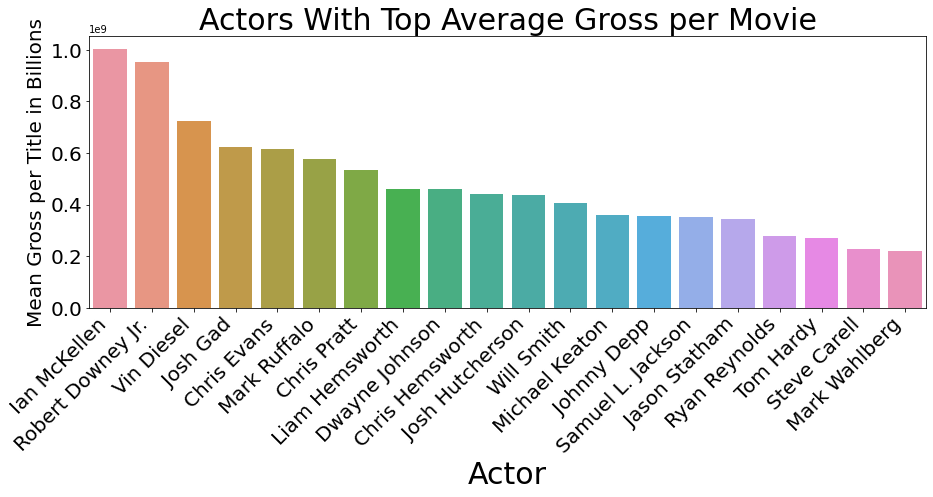

In [141]:
# setting figsize
fig, ax = plt.subplots(figsize=(15, 5))
# plotting
ax = sns.barplot(x='Actor', y='Mean Gross per Title', data=top20_mean_gross)
#adjusting xticks
plt.xticks(rotation=45, ha='right')
ax.tick_params(labelsize=20) 
#label for x-axis 
ax.set_xlabel( "Actor", fontsize=30 ) 
#label for y-axis 
ax.set_ylabel( "Mean Gross per Title in Billions" , fontsize=20 )
# setting title
ax.axes.set_title("Actors With Top Average Gross per Movie", fontsize=30)

  
# render 
plt.show() 

In [ ]:
actress_df = df[df['category'].str.contains('actress')]
actress_df.head()

In [ ]:
top_actresses_films = actress_df.sort_values(by=['worldwide_gross'], ascending=False).head(50)
top_actresses_films[['primary_name', 'movie', 'worldwide_gross', 'release_date']].head()

In [ ]:
years3 = top_actresses_films.release_date.unique()
print(years3)
print(len(years3))
np.sort(years3)

In [ ]:
top20_grossing_actresses = actress_df.groupby(['primary_name']).worldwide_gross.sum().sort_values(ascending=False).head(20)
top20_grossing_actresses

In [ ]:
director_df = df[df['category'].str.contains('director')]
director_df.head(1)

In [ ]:
top_directors_films = director_df.sort_values(by=['worldwide_gross'], ascending=False).head(20)
top_directors_films[['primary_name', 'movie', 'worldwide_gross', 'release_date']].head()

In [ ]:
top20_grossing_directors = director_df.groupby(['primary_name']).worldwide_gross.sum().sort_values(ascending=False).head(20)
top20_grossing_directors

In [ ]:
producer_df = df[df['category'].str.contains('producer')]
producer_df.head()

In [ ]:
top_producers_films = producer_df.sort_values(by=['worldwide_gross'], ascending=False).head(20)
top_producers_films[['primary_name', 'movie', 'worldwide_gross', 'release_date']].head()

In [ ]:
top20_grossing_producers = producer_df.groupby(['primary_name']).worldwide_gross.sum().sort_values(ascending=False).head(20)
top20_grossing_producers

In [ ]:
writer_df = df[df['category'].str.contains('writer')]
writer_df.head()

In [ ]:
top_writers_films = writer_df.sort_values(by=['worldwide_gross'], ascending=False).head(20)
top_writers_films[['primary_name', 'movie', 'worldwide_gross', 'release_date']].head()

In [ ]:
top20_grossing_writers = writer_df.groupby(['primary_name']).worldwide_gross.sum().sort_values(ascending=False).head(20)
top20_grossing_writers